In [1]:
#!/usr/bin/python
# updated DBR 04/2023 #

%matplotlib inline

import numpy as np
import pandas as pd
import os
import scipy.optimize as opt #for power law fitting
import matplotlib.pyplot as plt

#my power law fitter, for smaller sample sizes
import ra_module

import warnings
warnings.filterwarnings(action='once')


In [2]:
#some hardcoded info

#not using PWH122 and MACS14218
PWH_ppts = ['PWH22','PWH548','PWH746','PWH583',]
ctl_ppts = ['MACS10136','MACS13042','MACS14173','WIHS']

#colors for each cohort/person
PWH_cz=['salmon','peru','tab:red','maroon',]#,'firebrick']
ctl_cz=['lightblue','teal','tab:blue','navy']#,'turquoise']
#ctl_cz=['greenyellow','palegreen','forestgreen','darkgreen']#,'turquoise']

DNcolor='tab:green' #'tab:purple'
DELcolor='tab:purple'

## Sample sizes!
sample_size=10000 #10k
HIVsize=60 #for downsampling to match HIV? Maybe this needs to be participant specific


In [3]:
#read in and fix PWH provirus data

pdf = pd.read_csv('PWHproviral.csv') #proviral data

pidTl=[]
for i in range(len(pdf)):
    
    pid=pdf['pid'].iloc[i]
    ARTmo=pdf['monthsART'].iloc[i]
    
    if pdf['monthsART'].iloc[i]==np.min(pdf[pdf['pid']==pid]['monthsART']):
        tpn='_t1'
    else:
        tpn='_t2'
        
    pidTl.append('PWH'+str(pid)+tpn)

pdf['pidT']=pidTl
    
pdf.to_csv('PWHproviral-fixed.csv')

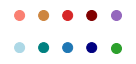

In [4]:
#check on colors
plt.figure(figsize=(2,1))
plt.scatter(range(4),np.ones(4),c=PWH_cz,s=100)
plt.scatter(range(4),np.ones(4)-1,c=ctl_cz,s=100)
plt.scatter(4,1,c=DELcolor,s=100)
plt.scatter(4,0,c=DNcolor,s=100)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/_colorlegend.pdf',dpi=600)

In [5]:
#functions for distribution fitting

#ecology calculations from resampled list of abundances

def calc_ecol(rs):
    l=rs[rs>0] #just keep nonzero
    R=len(l);  
    r=np.arange(R)+1
    a=-np.sort(-l)
    N=np.sum(a)
    pars=a/N
    cpa=np.cumsum(pars)
    
    D1=np.exp(-np.sum(pars*np.log(pars))) 
    D2=1/np.sum(pars**2)
    
    maxclone=a[0]/N
    
    top10clones=np.sum(a[:10])/N
    
    clonalf=np.sum(a[a>1])/N
    
    return r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf

#single power law
def pwl1(xx):
    al1=xx
    model_pa= r**-al1
    return model_pa/np.sum(model_pa)

#2 phase power law
def pwl2(xx):    
    al1,al2,psi=xx
    model_pa= r**-al1 + 1/psi*r**-al2
    return model_pa/np.sum(model_pa)
        
#calculate error for distribution, species abundance distribution
def SAD_error(xx):
    
    if dist_name=='pwl1':
        model_pa=pwl1(xx)
        
    if dist_name=='pwl2':
        model_pa=pwl2(xx)
           
    RMS = np.sqrt(np.mean((cpa[:maxr]-np.cumsum(model_pa[:maxr]))**2))
    #KS = np.max(cpa[:maxr]-np.cumsum(model_pa[:maxr]))
    #error=RMS
    return RMS

#had ried other models in past... check older code

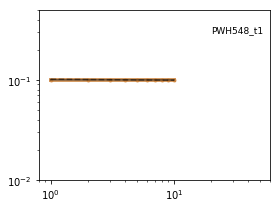

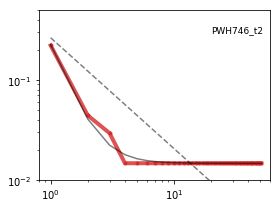

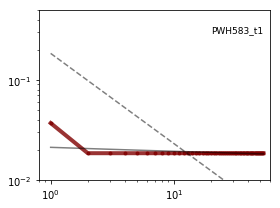

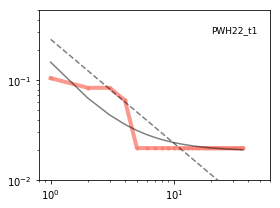

In [6]:
#repeat HIV provirus calculations here?!
#note take out 1211
#importantly, need list of N for the HIV people to do downsampling of TCR correctly

fit_l=[]
for pidT in ['PWH548_t1', 'PWH548_t2', 'PWH746_t1', 'PWH746_t2', 'PWH583_t1', 'PWH583_t2', 'PWH22_t1', 'PWH22_t2']:
    
    tdf = pdf[pdf['pidT']==pidT]
    
    Ni=sum(tdf['counts'])
    pa = tdf['counts']/Ni #original proportional abundance

    rsH = tdf['counts'] #original abundances (no need to downsample?)
    
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=calc_ecol(rsH) #ecology metrics

    maxr=len(a) #here want to fit singletons since fewer len(a[a>1]) #fit to non singletons? or shoudl this be a fixed

    res_l=[pidT,Ni,maxr,R,D1,D2,maxclone,top10clones,clonalf] #output metrics and put together

    dist_name='pwl1'
    result1 = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                           bounds=[[0.01,2.]], method='L-BFGS-B')
    dist_name='pwl2'
    result2 = opt.minimize(SAD_error,x0=[1.1,0.3,10.],tol=1e-15, 
                           bounds=[[0.001,100.],[0.001,3.],[1.,100]], method='L-BFGS-B')

    for res in [result1,result2]:
        res_l+=[res.fun]+list(res.x)
    
    #run the sampler version of alpha fitting, from the extra .py code
    fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=30,num_replicates=3,dat_abund=a,R=10**6,max_al=2)
    best_al=fit_al[np.argmin(fit_score[0])]

    res_l+=[best_al]
    fit_l.append(res_l)

    if pidT in ['PWH22_t1','PWH548_t1','PWH746_t2','PWH583_t1']:
        plt.figure(figsize=(4,3))
        
        cz=PWH_cz[PWH_ppts.index(pidT.split('_')[0])] #color

        plt.plot(r,pars,ls='-',label='data',color=cz,lw=4,alpha=0.8,marker='.')
        plt.loglog(r,pwl1(best_al),color='k',label='single',alpha=0.5,ls='--')
        plt.loglog(r,pwl2(result2.x),color='k',label='double',alpha=0.5)
        plt.annotate(pidT,[20,0.3],fontsize=9)

        plt.xlim([0.8,60])
        plt.ylim([1e-2,0.5])

        plt.tight_layout()
        plt.savefig('figures/fitexamplesHIV'+pidT+'.pdf',dpi=600)

#dataframe for ecology of proviruses (for PWH)
ecol_df_PWH_provirus = pd.DataFrame(fit_l,columns=['pid','NHIV','nonsingleton_RHIV',
                                          'RHIV','D1HIV','D2HIV','cmaxHIV','c10HIV','cfracHIV',
                                          'RMS1HIV','alHIV','RMS2HIV','alpha1HIV','alpha2HIV','phiHIV','alHIVsample'])



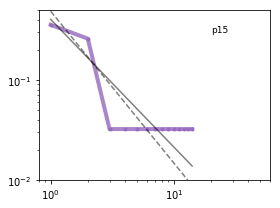

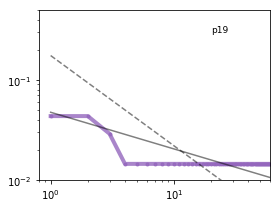

In [7]:
#also do reanalysis for DELSPC

pdfD=pd.read_csv('DELSPC_controlonly-dbr.csv')

fit_l=[]
for pid in list(pdfD.columns[1:]):
    counts = pdfD[pid].dropna().values
    
    Ni=sum(counts)
    pa = counts/Ni #original proportional abundance

    #original abundances (no need to downsample?)
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=calc_ecol(counts) #ecology metrics

    maxr=len(a[a>1]) #fit to non singletons? or shoudl this be a fixed

    res_l=['DELSPC'+pid[1:],Ni,maxr,R,D1,D2,maxclone,top10clones,clonalf] #output metrics and put together

    dist_name='pwl1'
    result1 = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                           bounds=[[0.01,2.]], method='L-BFGS-B')
    dist_name='pwl2'
    result2 = opt.minimize(SAD_error,x0=[1.1,0.3,10.],tol=1e-15, 
                           bounds=[[0.001,100.],[0.001,3.],[1.,100]], method='L-BFGS-B')

    for res in [result1,result2]:
        res_l+=[res.fun]+list(res.x)
    
    fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=30,num_replicates=3,dat_abund=a,R=10**6,max_al=2)
    best_al=fit_al[np.argmin(fit_score[0])]

    res_l+=[best_al]
    fit_l.append(res_l)

    cz=DELcolor #color

    if pid=='p15' or pid=='p19':
        plt.figure(figsize=(4,3))
        plt.plot(r,pars,ls='-',label='data',color=cz,lw=4,alpha=0.8,marker='.')
        plt.loglog(r,pwl1(best_al),color='k',label='single',alpha=0.5,ls='--')
        plt.loglog(r,pwl2(result2.x),color='k',label='double',alpha=0.5)
        plt.annotate(pid,[20,0.3],fontsize=9)

        plt.xlim([0.8,60])
        plt.ylim([1e-2,0.5])

        plt.tight_layout()
        plt.savefig('figures/fitexamplesD'+pid+'.pdf',dpi=600)

#dataframe for ecology of proviruses (for DEL)
ecol_df_DEL_provirus = pd.DataFrame(fit_l,columns=['pid','NHIV','nonsingleton_RHIV',
                                          'RHIV','D1HIV','D2HIV','cmaxHIV','c10HIV','cfracHIV',
                                          'RMS1HIV','alHIV','RMS2HIV','alpha1HIV','alpha2HIV','phiHIV','alHIVsample'])



In [12]:
#get all TCR file names
fns = os.listdir('cleanTCRdata/')
fns.remove('.DS_Store') #drop hidden file
fns.remove('restricted') #drop this folder

if 'DELSPC26.csv' in fns:
    fns.remove('DELSPC26.csv') #drop this ppt because no proviruses, but there is TCR data

fns.sort()

len(fns)

66

In [13]:
#loop through and fit all TCR and calculate ecology using "cleanTCRdata" folder

fit_l=[]
for i,fn in enumerate(fns):
    
    #add HIV status and color
    if 'dN' in fn:
        cz=DNcolor #color
        hz=0 #HIV status
        cohort='DN'
        cnum=4
        HIVsize=60
                
    if 'DELSPC' in fn:
        cz=DELcolor #color
        hz=1 #HIV status            
        cohort='DEL'
        cnum=3
        
        HIVsize=ecol_df_DEL_provirus[ecol_df_DEL_provirus['pid']==fn[:-4]]['NHIV'].iloc[0]
        print(HIVsize)
    
    if 'PWH' in fn:
        cz=PWH_cz[PWH_ppts.index(fn.split('_')[0])] #color
        hz=1 #HIV status  
        cohort='PWH'
        cnum=1
        
        if 't0' in fn[:-4]:
            HIVsize=60
        else:
            HIVsize=ecol_df_PWH_provirus[ecol_df_PWH_provirus['pid']==fn[:-4]]['NHIV'].iloc[0]
        print(HIVsize)

    if fn.split('_')[0] in ctl_ppts:
        cz=ctl_cz[ctl_ppts.index(fn.split('_')[0])] #color
        hz=0 #HIV status  
        cohort='Ctl'
        cnum=2
        
        HIVsize=60

    #now make resampled dataframes
    good_df=pd.read_csv('cleanTCRdata/'+fn)
    Ni=np.sum(good_df['templates']); #sample size originally
    pa = good_df['templates']/np.sum(good_df['templates']) #original proportional abundance
        
    rs1 = np.random.multinomial(n=sample_size,pvals=pa) #resampled abundance
    rsH = np.random.multinomial(n=HIVsize,pvals=pa) #resampled abundance

    out1=calc_ecol(rs1) #ecology metrics
    outH=calc_ecol(rsH) #ecology metrics at HIV sample size
            
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=out1 #metrics
    rH,aH,parsH,cpaH,RH,D1H,D2H,maxcloneH,top10clonesH,clonalfH=outH #metrics for HIV downsampled

    maxr=len(a[a>1]) #fit to non singletons? or shoudl this be a fixed
    
    res_l=[fn.split('.')[0],cohort,cnum,hz,Ni,sample_size,HIVsize,cz,maxr,
           R,D1,D2,maxclone,top10clones,clonalf,
           RH,D1H,D2H,maxcloneH,top10clonesH,clonalfH] #output metrics and put together

    dist_name='pwl1'
    result1 = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                           bounds=[[0.01,2.]], method='L-BFGS-B')
    dist_name='pwl2'
    result2 = opt.minimize(SAD_error,x0=[1.1,0.3,10.],tol=1e-15, 
                           bounds=[[0.001,100.],[0.001,3.],[1.,100]], method='L-BFGS-B')

    for res in [result1,result2]:
        res_l+=[res.fun]+list(res.x)
    fit_l.append(res_l)



95.0
131.0
31.0
68.0
63.0
61.0
69.0
60
48
41
60
10
93
60
54
58
60
86
68


In [14]:
#make ecol df
ecol_df_all_TCR = pd.DataFrame(fit_l,columns=['pid','cohort','cohort_num','HIVstatus',
                                      'initial_N','resample_size_TCR','resample_size_HIV',
                                      'color','nonsingleton_R',
                                      'R','D1','D2','cmax','c10','cfrac',
                                      'RH','D1H','D2H','cmaxH','c10H','cfracH',
                                      'RMS1','al','RMS2','alpha1','alpha2','phi'])

ecol_df_all_TCR.head()

,pid,cohort,cohort_num,HIVstatus,initial_N,resample_size_TCR,resample_size_HIV,color,nonsingleton_R,R,...,D2H,cmaxH,c10H,cfracH,RMS1,al,RMS2,alpha1,alpha2,phi
0,DELSPC12,DEL,3,1,31935,10000,95.0,tab:purple,1712,7506,...,95.000000,0.010526,0.105263,0.000000,0.008664,0.378049,0.009007,35.128734,0.374634,1.000000
1,DELSPC13,DEL,3,1,135312,10000,131.0,tab:purple,913,8552,...,131.000000,0.007634,0.076336,0.000000,0.003615,0.350792,0.002378,11.275534,0.331536,5.940423
2,DELSPC15,DEL,3,1,125197,10000,31.0,tab:purple,1225,6479,...,31.000000,0.032258,0.322581,0.000000,0.009810,0.572678,0.003144,0.695056,0.145224,100.000000
3,DELSPC16,DEL,3,1,154011,10000,68.0,tab:purple,558,4025,...,10.803738,0.264706,0.529412,0.426471,0.070281,0.923864,0.061064,0.874627,1.801750,1.000000
4,DELSPC17,DEL,3,1,147283,10000,63.0,tab:purple,1076,5808,...,46.694118,0.063492,0.269841,0.174603,0.032690,0.669294,0.002027,1.603086,0.466359,21.175518


In [15]:
#extra calculations
ecol_df_all_TCR['cp']=ecol_df_all_TCR['phi']**(1/(ecol_df_all_TCR['alpha1']-ecol_df_all_TCR['alpha2'])) #calculate change points

#use 1 phase model when phi=1?


In [16]:
#also compute ecology for only the restricted dataframes
#"persistent" TCR
#note downsample to HIV provirus size in PWH, in ctl just use 60 for average size

fit_l=[]
for i,pid in enumerate(PWH_ppts+ctl_ppts):
    
    for tp in [1,2]:
        #now make resampled dataframes
        good_df=pd.read_csv('cleanTCRdata/restricted/'+pid+'_t'+str(tp)+'.csv')

        Ni=np.sum(good_df['templates']); #sample size originally
        pa = good_df['templates']/np.sum(good_df['templates']) #original proportional abundance

        rs1 = np.random.multinomial(n=sample_size,pvals=pa) #resampled abundance
        
        if pid in PWH_ppts:
            HIVsize=ecol_df_PWH_provirus[ecol_df_PWH_provirus['pid']==pid+'_t'+str(tp)]['NHIV'].iloc[0]
        else:
            HIVsize=60
        print(HIVsize)

        rsH = np.random.multinomial(n=HIVsize,pvals=pa) #resampled abundance

        out1=calc_ecol(rs1) #ecology metrics
        outH=calc_ecol(rsH) #ecology metrics at HIV sample size

        r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=out1 #metrics
        rHr,aHr,parsHr,cpaHr,RHr,D1Hr,D2Hr,maxcloneHr,top10clonesHr,clonalfHr=outH #restricted AND HIV size

        maxr=len(a[a>1]) #fit to non singletons? or shoudl this be a fixed

        res_l=[pid+'_t'+str(tp),maxr,R,D1,D2,maxclone,top10clones,clonalf,
                  RHr,D1Hr,D2Hr,maxcloneHr,top10clonesHr,clonalfHr] #output metrics and put together

        dist_name='pwl1'
        result1 = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                               bounds=[[0.01,2.]], method='L-BFGS-B')
        dist_name='pwl2'
        result2 = opt.minimize(SAD_error,x0=[1.1,0.3,10.],tol=1e-15, 
                               bounds=[[0.001,100.],[0.001,3.],[1.,100]], method='L-BFGS-B')

        for res in [result1,result2]:
            res_l+=[res.fun]+list(res.x)
        fit_l.append(res_l)


#make ecol df
ecol_df_persistent = pd.DataFrame(fit_l,columns=['pid','nonsingleton_Rr',
                                          'Rr','D1r','D2r','cmaxr','c10r','cfracr',
                                          'RHr','D1Hr','D2Hr','cmaxHr','c10Hr','cfracHr',
                                          'RMS1r','alr','RMS2r','alpha1r','alpha2r','phir'])


48
41
10
93
86
68
54
58
60
60
60
60
60
60
60
60


In [17]:
#read in clinical data etc and merge with these calculated dataframes

df_key = pd.read_excel('FullkeyST1.xlsx') #read in the clinical info

df_key = df_key[df_key['pid']!='DELSPC26'] #drop this one because does not have matching provirus

In [18]:
#merge on ecological dataframes from this script

dfm = pd.merge(df_key,ecol_df_all_TCR,on=['pid'],how='outer')
dfm = pd.merge(dfm,ecol_df_persistent,on=['pid'],how='outer')

#redo HIV clone analysis for PWH and DELSPC!
#df_HIV_key = pd.read_csv('HIVecol.csv')

ecol_df_provirus = ecol_df_DEL_provirus.append(ecol_df_PWH_provirus)

dfm = pd.merge(dfm,ecol_df_provirus,on=['pid'],how='outer')
#dfm = pd.merge(dfm,ecol_df_PWH_provirus,on=['pid'],how='outer')

dfm.to_csv('ecometrics_wprovirusrecalc.csv')

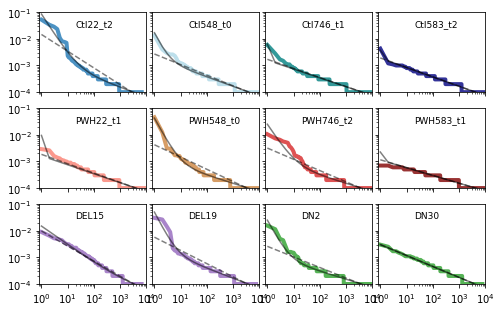

In [22]:
#make plots of TCR dist fits

fns=[
 'MACS14173_t2.csv',
 'MACS10136_t0.csv',
 'MACS13042_t1.csv',
 'WIHS_t2.csv',
 'PWH22_t1.csv',
 'PWH548_t0.csv',
 'PWH746_t2.csv',
 'PWH583_t1.csv',
 'DELSPC15.csv',
 'DELSPC19.csv',
 'dN02.csv',
 'dN30.csv',
]

nzl=[ 'Ctl22_t2','Ctl548_t0','Ctl746_t1','Ctl583_t2',
 'PWH22_t1','PWH548_t0','PWH746_t2','PWH583_t1',
 'DEL15','DEL19','DN2','DN30',]

fig,axs=plt.subplots(3,4,sharex=True,sharey=True,figsize=(8,5))

for i,fn in enumerate(fns):
    
    #add HIV status and color
    if 'dN' in fn:
        cz=DNcolor #color
    if 'DELSPC' in fn:
        cz=DELcolor #color
    if 'PWH' in fn:
        cz=PWH_cz[PWH_ppts.index(fn.split('_')[0])] #color
    if fn.split('_')[0] in ctl_ppts:
        cz=ctl_cz[ctl_ppts.index(fn.split('_')[0])] #color

    #now make resampled dataframes
    good_df=pd.read_csv('cleanTCRdata/'+fn)
    Ni=np.sum(good_df['templates']); #sample size originally
    pa = good_df['templates']/np.sum(good_df['templates']) #original proportional abundance
    
    rs1 = np.random.multinomial(n=sample_size,pvals=pa) #resampled abundance
    rsH = np.random.multinomial(n=HIVsize,pvals=pa) #resampled abundance

    out1=calc_ecol(rs1) #ecology metrics
    outH=calc_ecol(rsH) #ecology metrics at HIV sample size
            
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=out1 #metrics
    rH,aH,parsH,cpaH,RH,D1H,D2H,maxcloneH,top10clonesH,clonalfH=outH #metrics for HIV downsampled

    maxr=len(a[a>1]) #fit to non singletons? or shoudl this be a fixed
    
    dist_name='pwl1'
    result1 = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                           bounds=[[0.01,2.]], method='L-BFGS-B')
    dist_name='pwl2'
    result2 = opt.minimize(SAD_error,x0=[1.1,0.3,10.],tol=1e-15, 
                           bounds=[[0.001,100.],[0.001,3.],[1.,100]], method='L-BFGS-B')
    
    ax=axs[int(i/4)][i%4]
    
    ax.plot(r,pars,ls='-',label='data',color=cz,lw=4,alpha=0.8)
    ax.loglog(r,pwl1(result1.x),color='k',label='single',alpha=0.5,ls='--')
    ax.loglog(r,pwl2(result2.x),color='k',label='double',alpha=0.5)
    ax.annotate(nzl[i],[20,0.03],fontsize=9)

    ax.set_xlim([0.8,1e4])
    ax.set_ylim([1e-4,0.1])
    ax.set_xticks(np.logspace(0,4,5))
    
#plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.savefig('figures/fitexamples.pdf',dpi=600)
